In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycatch22
from tqdm import tqdm

def readInput(subset = 'train'):
    aortaDat = pd.read_csv(f'data/aortaP_{subset}_data.csv')
    aortaDat.rename({'Unnamed: 0': 'id'}, axis=1, inplace=True)
    brachDat = pd.read_csv(f'data/brachP_{subset}_data.csv')
    brachDat.rename({'Unnamed: 0': 'id'}, axis=1, inplace=True)

    if subset == 'train':
        targets = aortaDat[['id', 'target']]
        aortaDat = aortaDat.drop(['target'], axis=1)
        brachDat = brachDat.drop(['target'], axis=1)
    else:
        targets = None

    aortaDatLong = pd.melt(aortaDat, id_vars=['id'], var_name='time', value_name='aorta')
    brachDatLong = pd.melt(brachDat, id_vars=['id'], var_name='time', value_name='brach')

    aortaDatLong['time'] = aortaDatLong['time'].str.extract('(\d+)').astype(int)
    brachDatLong['time'] = brachDatLong['time'].str.extract('(\d+)').astype(int)

    merge_df = (
        brachDatLong
            .set_index(['id', 'time'])
            .join(aortaDatLong.set_index(['id', 'time']), how='outer', validate='one_to_one')
            .reset_index()
    )

    return (merge_df, targets)

def createFeatures(dat):
    dat['aoRank'] = dat.groupby('id').brach.rank(method="first", ascending=False)
    dat['brRank'] = dat.groupby('id').aorta.rank(method="first", ascending=False)

    aoTimes = (
        dat[dat.aoRank == 1][['id', 'time']]
            .rename({'time': 'aoTime'}, axis=1)
            .set_index('id')
    )

    brTimes = (
        dat[dat.brRank == 1][['id', 'time']]
            .rename({'time': 'brTime'}, axis=1)
            .set_index('id')
    )

    allTimes = aoTimes.join(brTimes, validate='one_to_one')
    allTimes['time_delta'] = allTimes['aoTime'] - allTimes['brTime']

    agg_df = (
        dat
            .groupby('id')
            .agg({'brach': 'max', 'aorta': 'max'})
    )

    agg_df['max_delta'] = agg_df['aorta'] - agg_df['brach']

    return agg_df.join(allTimes, validate='one_to_one')

In [3]:
X, y = readInput()

In [22]:
results = []
for i in tqdm(range(3499)):
    subset_dat = X[X['id'] == i].copy()

    subset_dat.brach.interpolate(method='linear', inplace=True)
    subset_dat.aorta.interpolate(method='linear', inplace=True)

    subset_dat.aorta.bfill(inplace=True)
    subset_dat.brach.bfill(inplace=True)

    subset_dat.aorta.ffill(inplace=True)
    subset_dat.brach.ffill(inplace=True)

    result = {
        'id': i,
    }

    for col in ['brach', 'aorta']:
        catch_result = pycatch22.catch22_all(subset_dat[col].values)
        for key, value in zip(catch_result['names'], catch_result['values']):
            result[f'{col}_{key}'] = value

    results.append(result)

result_df = pd.DataFrame(results)
result_df = result_df.set_index('id').join(y.set_index('id'))

100%|██████████| 3499/3499 [00:09<00:00, 358.81it/s]


In [23]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(result_df, test_size=0.2, random_state=42)

In [26]:
from lightgbm import LGBMClassifier
clf = LGBMClassifier()
clf.fit(train.drop("target", axis=1), train.target)
clf.score(test.drop("target", axis=1), test.target)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6764
[LightGBM] [Info] Number of data points in the train set: 2799, number of used features: 44
[LightGBM] [Info] Start training from score -1.797133
[LightGBM] [Info] Start training from score -1.784285
[LightGBM] [Info] Start training from score -1.765317
[LightGBM] [Info] Start training from score -1.816720
[LightGBM] [Info] Start training from score -1.797133
[LightGBM] [Info] Start training from score -1.790688


0.39

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

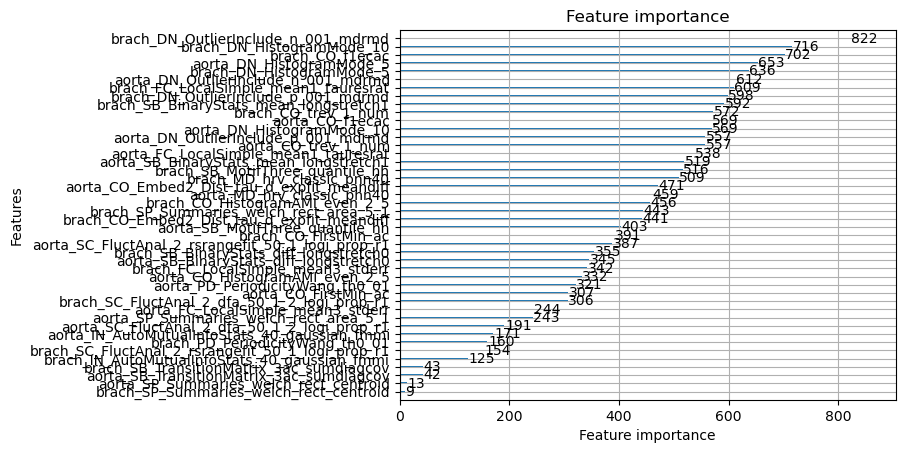

In [27]:
from lightgbm import plot_importance
plot_importance(clf)

Text(0.5, 1.0, 'Top N Accuracy')

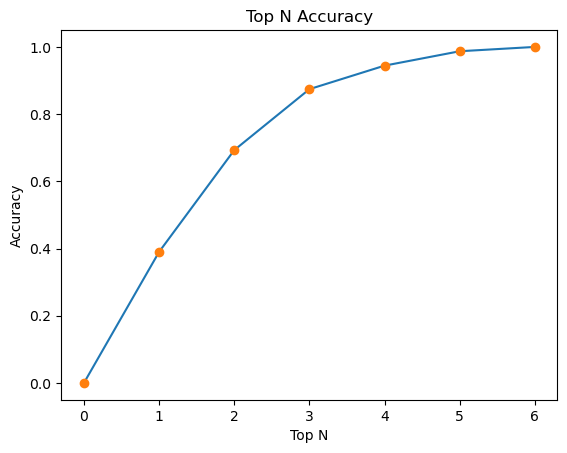

In [28]:
probs = clf.predict_proba(test.drop("target", axis=1))
sorts = np.argsort(-probs)
results = []
for n in range(7):
    score = np.mean([x[1] in x[0] for x in zip(sorts[:, 0:(n)], test.target)])
    results.append({
        'n': n,
        'score': score
    })

results_df = pd.DataFrame(results)

plt.plot(results_df['n'], results_df['score'])
plt.plot(results_df['n'], results_df['score'], 'o')
plt.xlabel('Top N')
plt.ylabel('Accuracy')
plt.title('Top N Accuracy')